In [1]:
import random
import h5py
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.optim import AdamW, Optimizer
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
PREFIX_PATH = '/kaggle/input/bci-rnn-raw-data'
WORKING_PATH = '/kaggle/working'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

RAND_STATE = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed(RAND_STATE)

cuda


In [3]:
labels_df = pd.read_csv(f'{PREFIX_PATH}/TrainLabels.csv')
train_labels = labels_df['Prediction'].to_numpy()
print(train_labels.shape)
label_stats = np.unique(train_labels, return_counts=True)
print(label_stats)

TRAIN_FEEDBACK_PATH = f'{PREFIX_PATH}/feedback_train.npy'
feedback_data = np.load(TRAIN_FEEDBACK_PATH)
TRAIN_GREEN_PATH = f'{PREFIX_PATH}/green_train.npy'
green_data = np.load(TRAIN_GREEN_PATH)
print(feedback_data.shape, green_data.shape)

TEST_FEEDBACK_PATH = f'{PREFIX_PATH}/feedback_test.npy'
feedback_test = np.load(TEST_FEEDBACK_PATH)
print(feedback_test.shape)

(5440,)
(array([0, 1]), array([1590, 3850]))
(5440, 16, 260) (5440, 16, 220)
(3400, 16, 260)


In [20]:
class BCIDataset(Dataset):
    def __init__(self, eeg_data, labels=None, sfreq=200, augment=False, 
                 p300_window=(250, 500), test_mode=False):
        """
        Args:
            eeg_data: numpy array of shape (n_trials, n_channels, n_samples)
            labels: numpy array of shape (n_trials,) or None for test set
            sfreq: Sampling frequency in Hz
            augment: Whether to apply data augmentation
            p300_window: Tuple of (start_ms, end_ms) for P300 window
            test_mode: If True, skips label validation
        """
        self.data = eeg_data
        self.labels = labels
        self.sfreq = sfreq
        self.augment = augment
        self.test_mode = test_mode
        self.p300_window = p300_window
        
        if not test_mode:
            self._validate_labels()
            
        # Convert P300 window to samples
        self.window_start = int(p300_window[0] * sfreq / 1000)
        self.window_end = int(p300_window[1] * sfreq / 1000)
        
        # Normalization parameters
        self.chan_mean = self.data.mean(axis=(0, 2), keepdims=True)
        self.chan_std = self.data.std(axis=(0, 2), keepdims=True)
        
    def _validate_labels(self):
        if self.labels is None:
            raise ValueError("Labels cannot be None in training mode")
        if len(self.data) != len(self.labels):
            raise ValueError("EEG data and labels must have same length")
        if not np.all(np.unique(self.labels) == [0, 1]):
            raise ValueError("Labels must be binary (0 and 1)")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get EEG trial (shape: n_channels, n_samples)
        x = self.data[idx]
        #print(1, x.shape)
        # Apply preprocessing
        x = self._preprocess(x)
        #print(2, x.shape)
        # Data augmentation
        if self.augment and not self.test_mode:
            x = self._augment(x)
        #print(3, x.shape)
        # Convert to torch tensor
        x = torch.FloatTensor(x)
        #print(4, x.shape)
        #print("Converted!")
        if self.test_mode:
            return x
        else:
            y = torch.FloatTensor([self.labels[idx]])
            return x, y
    
    def _preprocess(self, eeg_trial):
        """Apply preprocessing to a single trial"""
        # 1. Remove DC offset (per channel)
        eeg_trial = eeg_trial - np.mean(eeg_trial, axis=1, keepdims=True)
        
        # 2. Scale entire trial (preserves relative channel relationships)
        trial_std = np.std(eeg_trial) + 1e-8  # Small epsilon
        eeg_trial = eeg_trial / trial_std
        
        #print(eeg_trial.shape)
        return eeg_trial

    def _augment(self, eeg_trial):

        # Time warping
        if np.random.rand() < 0.4:
            warp_factor = np.random.uniform(0.9, 1.1)  # More conservative range
            orig_length = eeg_trial.shape[1]
            warped = np.zeros_like(eeg_trial)
            
            for c in range(eeg_trial.shape[0]):
                # Generate new time axis
                new_length = int(orig_length * warp_factor)
                x_new = np.linspace(0, orig_length-1, new_length)
                
                # Ensure we don't exceed bounds
                source_signal = eeg_trial[c, :min(new_length, orig_length)]
                
                # Interpolate
                warped[c] = np.interp(
                    np.arange(orig_length),  # Target x-values
                    x_new[:len(source_signal)],  # Source x-values
                    source_signal  # Source y-values
                )
            eeg_trial = warped
        
        # Gaussian noise
        if np.random.rand() < 0.3:
            eeg_trial = eeg_trial + np.random.normal(0, 0.1, size=eeg_trial.shape)

        # Channel dropout
        if np.random.rand() < 0.2:
            mask = np.ones(eeg_trial.shape[0])  # Preserve original channel count
            drop_idx = np.random.choice(
                eeg_trial.shape[0], 
                int(eeg_trial.shape[0]*0.1), 
                replace=False
            )
            mask[drop_idx] = 0
            eeg_trial = eeg_trial * mask[:, np.newaxis]  # Broadcast mask

        # P300 window jitter (with bounds checking)
        if np.random.rand() < 0.4 and hasattr(self, 'window_start'):
            max_jitter = min(10, self.window_start)  # Don't jitter beyond trial start
            jitter = np.random.randint(-max_jitter, max_jitter)
            jittered = np.roll(eeg_trial, jitter, axis=1)
            
            # Handle edge effects
            if jitter > 0:
                jittered[:, :jitter] = 0
            elif jitter < 0:
                jittered[:, jitter:] = 0
            eeg_trial = jittered
    
        # Amplitude modulation (with clipping)
        if np.random.rand() < 0.3:
            mod = np.random.uniform(0.8, 1.2, size=(eeg_trial.shape[0], 1))  # More conservative range
            eeg_trial = np.clip(eeg_trial * mod, -10, 10)  # Prevent extreme values
            
        return eeg_trial
    '''
    def _augment(self, eeg_trial):
        """Apply data augmentation to a single trial"""
        # 1. Gaussian noise
        if np.random.rand() < 0.3:
            eeg_trial = eeg_trial + np.random.normal(0, 0.1, size=eeg_trial.shape)

        #print(1, eeg_trial.shape)
        # 2. Channel dropout
        if np.random.rand() < 0.2:
            mask = np.ones(eeg_trial.shape[0])  # Preserve original channel count
            drop_idx = np.random.choice(
                eeg_trial.shape[0], 
                int(eeg_trial.shape[0]*0.1), 
                replace=False
            )
            mask[drop_idx] = 0
            eeg_trial = eeg_trial * mask[:, np.newaxis]  # Broadcast mask
        
        ' ''
        # 3. Time warping
        if np.random.rand() < 0.25:
            eeg_trial = self._time_warp(eeg_trial)
        ' ''
        #print(2, eeg_trial.shape)
        return eeg_trial
    '''
    def train_val_split(self, test_size=0.2, random_state=RAND_STATE):
        """Split dataset into train and validation sets"""
        if self.test_mode:
            raise ValueError("Cannot split test dataset")
            
        idx = np.arange(len(self))
        train_idx, val_idx = train_test_split(
            idx, test_size=test_size, 
            random_state=random_state,
            stratify=self.labels
        )
        
        train_set = BCIDataset(
            self.data[train_idx],
            self.labels[train_idx],
            sfreq=self.sfreq,
            augment=True
        )
        
        val_set = BCIDataset(
            self.data[val_idx],
            self.labels[val_idx],
            sfreq=self.sfreq,
            augment=False
        )
        
        return train_set, val_set

In [21]:
# Create dataset
full_dataset = BCIDataset(feedback_data, train_labels)

# Split into train/val
train_set, val_set = full_dataset.train_val_split(test_size=0.2)

print(f'full: {len(full_dataset)} - train: {len(train_set)}, val: {len(val_set)}')

batch_size = 32

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True
)

val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False,
)

test_set = BCIDataset(feedback_test, test_mode=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
print(len(test_set))

full: 5440 - train: 4352, val: 1088
3400


(260,)


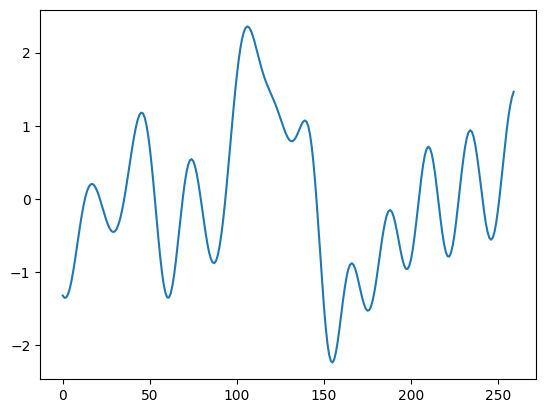

In [6]:
t = next(iter(test_loader))
x = np.array(t[0, 0].cpu())
print(x.shape)
plt.plot(x)

In [7]:
class P300DetectorV2(nn.Module):
    def __init__(self, n_channels=16, sfreq=200):
        super().__init__()
        
        # Temporal pathway (output: [batch, 32, time])
        self.temp_path = nn.Sequential(
            nn.Conv1d(n_channels, 32, kernel_size=int(0.3*sfreq), 
                     padding=int(0.3*sfreq)//2),
            nn.BatchNorm1d(32),
            nn.ELU(),
            nn.MaxPool1d(4),
            nn.Dropout(0.3)
        )
        
        # Late response pathway (output: [batch, 32, time])
        self.late_path = nn.Sequential(
            nn.Conv1d(n_channels, 32, kernel_size=int(0.5*sfreq),
                     padding=int(0.5*sfreq)//2),
            nn.BatchNorm1d(32),
            nn.ELU(),
            nn.MaxPool1d(4),
            nn.Dropout(0.3)
        )
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=1),
            nn.BatchNorm1d(64),
            nn.ELU(),
            nn.Conv1d(64, 1, kernel_size=1),
            nn.Sigmoid()
        )
        
        # LSTM temporal modeling
        self.lstm = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)
        
        # Classifier
        self.classifier = nn.Linear(64, 1)

    def forward(self, x):
        # Input shape: [batch, channels, time]
        
        # Temporal processing
        temp_out = self.temp_path(x)  # [batch, 32, time]
        late_out = self.late_path(x)  # [batch, 32, time]
        
        # Combine features
        x = torch.cat([temp_out, late_out], dim=1)  # [batch, 64, time]
        
        # Attention
        attn_weights = self.attention(x)  # [batch, 1, time]
        x = x * attn_weights
        
        # LSTM processing
        x = x.permute(0, 2, 1)  # [batch, time, 64]
        x, _ = self.lstm(x)
        
        # Classification
        x = x.mean(dim=1)  # [batch, 64]
        return self.classifier(x)

class P300InformedLoss(nn.Module):
    def __init__(self, sfreq=200, pos_weight=2.42):
        super().__init__()
        self.pos_weight = pos_weight
        # Create a Gaussian weight centered at 300ms (±100ms)
        time_points = torch.arange(0, 1.0, 1/sfreq)
        self.time_weights = torch.exp(-(time_points - 0.3)**2 / (2 * 0.1**2))
        
    def forward(self, preds, targets):
        # Apply time-domain weighting only to positive samples
        if preds.dim() > 1:  # If sequence predictions
            weighted_targets = targets.unsqueeze(1) * self.time_weights.to(preds.device)
            loss = F.binary_cross_entropy_with_logits(
                preds, weighted_targets,
                pos_weight=self.pos_weight
            )
        else:
            loss = F.binary_cross_entropy_with_logits(
                preds, targets,
                pos_weight=self.pos_weight
            )
        return loss

class P300Loss(nn.Module):
    def __init__(self, pos_weight=2.42):  # 3850/1590 ratio
        super().__init__()
        self.pos_weight = pos_weight
        
    def forward(self, preds, targets):
        loss = F.binary_cross_entropy(preds, targets, reduction='none')
        # Emphasize 250-500ms window errors
        if preds.dim() > 1:  # If using sequence outputs
            time_weights = torch.linspace(1, 3, preds.shape[1]).to(preds.device)
            loss = (loss * time_weights).mean()
        return loss.mean()

In [12]:
class ImprovedP300Detector(nn.Module):
    def __init__(self, n_channels=16):
        super().__init__()

        # Spatial attention
        self.spatial_att = nn.Sequential(
            nn.Conv1d(n_channels, 32, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(32, n_channels, kernel_size=1),
            nn.Sigmoid()
        )

        # Multi-scale temporal convolutions
        self.temporal_branches = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(n_channels, 32, kernel_size=k, padding=k//2),
                nn.BatchNorm1d(32),
                nn.ELU(),
                nn.MaxPool1d(4)
            ) for k in [25, 50, 75]  # ~125ms, 250ms, 375ms
        ])

        # Aggregation
        self.post_conv = nn.Sequential(
            nn.Conv1d(96, 64, kernel_size=3, padding=1),
            nn.ELU(),
            nn.AdaptiveAvgPool1d(1)  # Global temporal pooling
        )

        # Classification head
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 32),
            nn.ELU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x shape: (B, C=16, T=260)
        att = self.spatial_att(x)
        x = x * att

        feats = [branch(x) for branch in self.temporal_branches]  # Each (B, 32, T//4)
        x = torch.cat(feats, dim=1)  # (B, 96, T//4)

        x = self.post_conv(x)  # (B, 64, 1)
        return self.head(x).squeeze(-1), x.squeeze(-1)

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, preds, targets):
        preds = preds.clamp(1e-6, 1 - 1e-6)
        BCE = F.binary_cross_entropy(preds, targets, reduction='none')
        pt = torch.exp(-BCE)
        loss = self.alpha * (1 - pt) ** self.gamma * BCE
        return loss.mean()

In [11]:
def save_best(model, best_auc, val_auc, output):
    torch.save(model.state_dict(), f"{WORKING_PATH}/{output}")
    print(f"↳ New best AUC: {best_auc:.4f}")

In [10]:
def validate(model, loader, device):
    model.eval()
    probs, labels = [], []
    with torch.no_grad():
        for inputs, targets in loader:
            outputs = model(inputs.to(device))
            probs.extend(torch.sigmoid(outputs).cpu().numpy())
            labels.extend(targets.numpy())
    return roc_auc_score(labels, probs)

# Hyperparameters
config = {
    "phase1": {"epochs": 10, "lr": 3e-4, "freeze": True},
    "phase2": {"epochs": 20, "lr": 1e-4, "freeze": False},
    "phase3": {"epochs": 10, "lr": 5e-5, "focus_window": (200, 400)}
}

def train_model(train_loader, val_loader, device):
    # Initialize
    model = P300DetectorV2(n_channels=16, sfreq=200).to(device)
    
    # Loss with P300 time weighting
    #criterion = P300InformedLoss(sfreq=200, pos_weight=torch.tensor([2.42]).to(device))
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3850/1590]).to(device))
    
    # Phase 1: Feature Extraction
    print("=== Phase 1: Spatial-Temporal Feature Learning ===")
    for name, param in model.named_parameters():
        if not name.startswith("temp_path"):  # Freeze all but temporal path
            param.requires_grad = False

    optimizer = torch.optim.AdamW(model.parameters(), config["phase1"]["lr"], weight_decay=1e-3)
    scheduler = CosineAnnealingLR(optimizer, T_max=config["phase1"]["epochs"])
    train_phase(model, train_loader, val_loader, criterion, optimizer, scheduler, 
               config["phase1"]["epochs"], device, 1)
    
    # Phase 2: Full Model Fine-Tuning
    print("\n=== Phase 2: Full Model Optimization ===")
    for param in model.parameters():  # Unfreeze all
        param.requires_grad = True
        
    optimizer = torch.optim.AdamW(model.parameters(), lr=config["phase2"]["lr"])
    scheduler = ReduceLROnPlateau(optimizer, mode="max", patience=3)
    train_phase(model, train_loader, val_loader, criterion, optimizer, scheduler,
               config["phase2"]["epochs"], device, 2)
    
    # Phase 3: P300 Window Focus
    optimizer = torch.optim.AdamW(model.parameters(), lr=config["phase3"]["lr"])
    print("\n=== Phase 3: Temporal Window Refinement ===")
    window_start = int(config["phase3"]["focus_window"][0] * 200 / 1000) # fs=200
    window_end = int(config["phase3"]["focus_window"][1] * 200 / 1000)

    best_auc = 0.0
    for epoch in range(config["phase3"]["epochs"]):
        model.train()
        for x, y in train_loader:
            x = x[:, :, window_start:window_end].to(device)  # Focus window
            y = y.to(device)
            
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(torch.sigmoid(outputs), y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        
        # Validation (full signal)
        val_auc = validate(model, val_loader, device)
        print(f"Epoch {epoch+1}: Val AUC = {val_auc:.4f}")
        if val_auc > best_auc:
            best_auc = val_auc
            save_best(model, best_auc, val_auc, f"best_p300_phase3.pth")

    return model

def train_phase(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, device, phase):
    best_auc = 0
    for epoch in range(epochs):
        model.train()
        for x, y in train_loader: # feedback, label
            x, y = x.to(device), y.to(device)
            #print('from train', x.shape, y.shape)
            optimizer.zero_grad()
            outputs = model(x)
            #print(outputs.shape) # (32, 1)
            loss = criterion(torch.sigmoid(outputs), y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        
        # Validation
        val_auc = validate(model, val_loader, device)
        print(f"Epoch {epoch+1}: Val AUC = {val_auc:.4f}")
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(val_auc)
        else:
            scheduler.step()
            
        if val_auc > best_auc:
            best_auc = val_auc
            save_best(model, best_auc, val_auc, f"best_p300_phase{phase}.pth")

In [11]:
trained_detector = train_model(train_loader, val_loader, device)

=== Phase 1: Spatial-Temporal Feature Learning ===
Epoch 1: Val AUC = 0.5346
↳ New best AUC: 0.5346
Epoch 2: Val AUC = 0.5652
↳ New best AUC: 0.5652
Epoch 3: Val AUC = 0.5848
↳ New best AUC: 0.5848
Epoch 4: Val AUC = 0.5815
Epoch 5: Val AUC = 0.5823
Epoch 6: Val AUC = 0.5718
Epoch 7: Val AUC = 0.5651
Epoch 8: Val AUC = 0.5238
Epoch 9: Val AUC = 0.5394
Epoch 10: Val AUC = 0.5470

=== Phase 2: Full Model Optimization ===
Epoch 1: Val AUC = 0.4702
↳ New best AUC: 0.4702
Epoch 2: Val AUC = 0.5071
↳ New best AUC: 0.5071
Epoch 3: Val AUC = 0.5111
↳ New best AUC: 0.5111
Epoch 4: Val AUC = 0.5142
↳ New best AUC: 0.5142
Epoch 5: Val AUC = 0.5136
Epoch 6: Val AUC = 0.5154
↳ New best AUC: 0.5154
Epoch 7: Val AUC = 0.5147
Epoch 8: Val AUC = 0.5152
Epoch 9: Val AUC = 0.5159
↳ New best AUC: 0.5159
Epoch 10: Val AUC = 0.5187
↳ New best AUC: 0.5187
Epoch 11: Val AUC = 0.5168
Epoch 12: Val AUC = 0.5208
↳ New best AUC: 0.5208
Epoch 13: Val AUC = 0.5205
Epoch 14: Val AUC = 0.5210
↳ New best AUC: 0.5210
E

In [42]:
class EEG2DNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Use torchvision's ResNet18
        self.base = models.resnet18(pretrained=False)
        
        # Modify first conv layer for 1-channel input
        self.base.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Adjust final fully connected layer
        self.base.fc = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Input shape: (B, 16, 260) → reshape to (B, 1, 16, 260)
        x = x.unsqueeze(1)
        return self.base(x).squeeze(1)

class ChannelAttention(nn.Module):
    def __init__(self, channels=16):
        super().__init__()
        self.attn = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),             # shape: (B, C, 1)
            nn.Conv1d(channels, channels, 1),    # shape: (B, C, 1)
            nn.Sigmoid()
        )

    def forward(self, x):  # x: (B, 16, 260)
        w = self.attn(x)   # (B, 16, 1)
        return x * w       # apply weights to each channel

class EEG2DNetWithAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.channel_attn = ChannelAttention(channels=16)
        
        self.base = models.resnet18(pretrained=False)
        self.base.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.base.fc = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):  # x: (B, 16, 260)
        x = self.channel_attn(x)        # Apply channel attention
        x = x.unsqueeze(1)              # (B, 1, 16, 260)
        return self.base(x).squeeze(1)  # Output: (B,)

In [46]:
class ChannelAttention(nn.Module):
    def __init__(self, channels=16):
        super().__init__()
        self.attn = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),             # shape: (B, C, 1)
            nn.Conv1d(channels, channels, 1),    # shape: (B, C, 1)
            nn.Sigmoid()
        )

    def forward(self, x):  # x: (B, 16, 260)
        # Remove the extra dimension before applying attention
        B, C, L = x.shape  # B: batch size, C: number of channels, L: length of signal
        x_reshaped = x.view(B, C, L)  # Ensure it's in shape (B, C, L)

        w = self.attn(x_reshaped)   # (B, C, 1)
        return x * w.expand_as(x)    # apply weights to each channel

class TemporalAttention(nn.Module):
    def __init__(self, channels=16):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Conv1d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(channels, 1, kernel_size=1)
        )

    def forward(self, x):
        w = self.attn(x)  # (B, 1, T)
        w = torch.softmax(w, dim=-1)
        return x * w

class EEG2DNetWithTemporalConv(nn.Module):
    def __init__(self):
        super().__init__()
        # Temporal convolution to capture time-related dependencies
        self.temporal_conv = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
        self.temporal_attn = TemporalAttention(channels=32)
        self.channel_attn = ChannelAttention(channels=32)
        
        self.base = models.resnet50(pretrained=False)
        self.base.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.base.fc = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.squeeze(1)  # Remove channel dimension for 1D convolution
        x = self.temporal_conv(x)  # Apply 1D temporal convolution
        x = self.temporal_attn(x)  # Temporal attention
        x = self.channel_attn(x)  # Channel attention
        x = x.unsqueeze(1)  # Add channel dimension for ResNet
        return self.base(x).squeeze(1)

In [55]:
class EEG2DNetWithGRU(nn.Module):
    def __init__(self):
        super().__init__()
        self.temporal_conv = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
        #self.temporal_attn = TemporalAttention(channels=32)
        #self.channel_attn = ChannelAttention(channels=32)

        # GRU for temporal sequence learning
        self.gru = nn.GRU(input_size=32, hidden_size=64, num_layers=2, batch_first=True)

        # Fully connected layers for classification
        self.base = models.resnet18(pretrained=False)
        self.base.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.base.fc = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.squeeze(1)  # Remove the channel dimension for Conv1D
        x = self.temporal_conv(x)  # Temporal convolution layer
        #x = self.temporal_attn(x)  # Temporal attention
        #x = self.channel_attn(x)  # Channel attention

        # Reshape for GRU: GRU expects (B, seq_len, features)
        x = x.transpose(1, 2)  # (B, seq_len, features)
        x, _ = self.gru(x)  # GRU layer, capturing temporal dependencies

        # Take the last output from the GRU 
        x = x[:, -1, :]  # Last hidden state from GRU
        x = x.unsqueeze(1)  # Add back the channel dimension for ResNet
        x = x.unsqueeze(3)
        #print(x.shape)
        return self.base(x).squeeze(1)  # Final classification using ResNet

In [59]:
class EEGNetWithP300Conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.temporal_conv = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
        self.p300_conv = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=60, padding=30)

        self.channel_attn = ChannelAttention(channels=64)
        self.temporal_attn = TemporalAttention(channels=64)

        self.base = models.resnet18(pretrained=False)
        self.base.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.base.fc = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.squeeze(1)  # (B, 16, T)
        x = self.temporal_conv(x)   # (B, 32, T)
        x = self.p300_conv(x)       # (B, 64, T)

        x = self.channel_attn(x)
        x = self.temporal_attn(x)

        # Flatten or reshape for ResNet
        x = x.unsqueeze(1)  # (B, 1, 64, T)
        return self.base(x).squeeze(1)

In [60]:
#model = ImprovedP300Detector().to(device)
#model = EEG2DNet().to(device)
#model = EEG2DNetWithAttention().to(device)
#model = EEG2DNetWithTemporalConv().to(device)
model = EEGNetWithP300Conv().to(device)
criterion = FocalLoss(alpha=0.25, gamma=2.0)
#optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

num = 8

def get_optimizer_for_phase(model, phase):
    if phase == 1:
        lr = 2e-3
    elif phase == 2:
        lr = 5e-4
    else:  # phase == 3
        lr = 1e-5 #1e-5
    
    return torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

def validate(model, loader, device):
    model.eval()
    probs, labels = [], []
    with torch.no_grad():
        for inputs, targets in loader:
            #outputs, _ = model(inputs.to(device))
            outputs = model(inputs.to(device))
            probs.extend(outputs.cpu().numpy())
            labels.extend(targets.numpy())
    return roc_auc_score(labels, probs)

def train_epochs(model, train_loader, criterion, optimizer, scheduler, n_epochs, phase):
    best_auc = 0.0
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            if phase == 3: x = x[:, :, 50:130] # focus on P300
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()
            #preds, _ = model(x)
            preds = model(x)
            #print(preds.shape, y.squeeze(1).shape)
            loss = criterion(preds, y.squeeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x.size(0)
    
        avg_loss = running_loss / len(train_loader.dataset)
        val_auc = validate(model, val_loader, device)
        scheduler.step(val_auc)
        
        print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Val AUC: {val_auc:.4f}") 
        if val_auc > best_auc:
            best_auc = val_auc
            save_best(model, best_auc, val_auc, f'best_p300_phase{phase}_{num}.pth') 
    return model

print("===== Phase 1 =====")
for name, param in model.named_parameters():
    if name.startswith("base") and not name.startswith("base.fc"):
        param.requires_grad = False
    else:
        param.requires_grad = True
model = train_epochs(model, train_loader, criterion, get_optimizer_for_phase(model, 1), scheduler, 5, 1)
model.load_state_dict(torch.load(f'/kaggle/working/best_p300_phase1_{num}.pth'))

print("===== Phase 2 =====")
for name, param in model.named_parameters():
    if "layer4" in name or "layer3" in name or name.startswith("base.fc"):
        param.requires_grad = True
    elif name.startswith("base"):
        param.requires_grad = False
    else:
        param.requires_grad = True
model = train_epochs(model, train_loader, criterion, get_optimizer_for_phase(model, 2), scheduler, 10, 2)
model.load_state_dict(torch.load(f'/kaggle/working/best_p300_phase2_{num}.pth'))

print("===== Phase 3 =====")
for param in model.parameters():
    param.requires_grad = True
model = train_epochs(model, train_loader, criterion, get_optimizer_for_phase(model, 3), scheduler, 10, 3)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


===== Phase 1 =====
Epoch 1 | Loss: 0.0402 | Val AUC: 0.5346
↳ New best AUC: 0.5346
Epoch 2 | Loss: 0.0387 | Val AUC: 0.5349
↳ New best AUC: 0.5349
Epoch 3 | Loss: 0.0383 | Val AUC: 0.5290
Epoch 4 | Loss: 0.0387 | Val AUC: 0.5425
↳ New best AUC: 0.5425
Epoch 5 | Loss: 0.0387 | Val AUC: 0.5392
===== Phase 2 =====


/tmp/ipykernel_31/2964936862.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/kaggle/working/best_p300_phase1_{num}.pth'))


Epoch 1 | Loss: 0.0386 | Val AUC: 0.5241
↳ New best AUC: 0.5241
Epoch 2 | Loss: 0.0384 | Val AUC: 0.5439
↳ New best AUC: 0.5439
Epoch 3 | Loss: 0.0381 | Val AUC: 0.5457
↳ New best AUC: 0.5457
Epoch 4 | Loss: 0.0382 | Val AUC: 0.5437
Epoch 5 | Loss: 0.0381 | Val AUC: 0.5355
Epoch 6 | Loss: 0.0380 | Val AUC: 0.5456
Epoch 7 | Loss: 0.0379 | Val AUC: 0.5388
Epoch 8 | Loss: 0.0379 | Val AUC: 0.5457
↳ New best AUC: 0.5457
Epoch 9 | Loss: 0.0379 | Val AUC: 0.5357
Epoch 10 | Loss: 0.0380 | Val AUC: 0.5450
===== Phase 3 =====


/tmp/ipykernel_31/2964936862.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/kaggle/working/best_p300_phase2_{num}.pth'))


Epoch 1 | Loss: 0.0383 | Val AUC: 0.5465
↳ New best AUC: 0.5465
Epoch 2 | Loss: 0.0381 | Val AUC: 0.5478
↳ New best AUC: 0.5478
Epoch 3 | Loss: 0.0380 | Val AUC: 0.5401
Epoch 4 | Loss: 0.0378 | Val AUC: 0.5391
Epoch 5 | Loss: 0.0378 | Val AUC: 0.5400
Epoch 6 | Loss: 0.0376 | Val AUC: 0.5364
Epoch 7 | Loss: 0.0375 | Val AUC: 0.5372
Epoch 8 | Loss: 0.0372 | Val AUC: 0.5378
Epoch 9 | Loss: 0.0372 | Val AUC: 0.5367
Epoch 10 | Loss: 0.0369 | Val AUC: 0.5376


In [61]:
class ChannelAttention(nn.Module):
    def __init__(self, channels=16):
        super().__init__()
        self.attn = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),             # shape: (B, C, 1)
            nn.Conv1d(channels, channels, 1),    # shape: (B, C, 1)
            nn.Sigmoid()
        )

    def forward(self, x):  # x: (B, C, T)
        w = self.attn(x)   # (B, C, 1)
        return x * w.expand_as(x)  # Apply weights to each channel

class EEGNetWithP300Conv(nn.Module):
    def __init__(self, input_channels=16, conv_out_channels=32, kernel_size=60, num_classes=1):
        super().__init__()
        
        # Temporal convolution layer to capture P300-related temporal features
        self.temporal_conv = nn.Conv1d(input_channels, conv_out_channels, kernel_size=kernel_size, padding=kernel_size//2)
        
        # Channel Attention mechanism
        self.channel_attn = ChannelAttention(channels=conv_out_channels)
        
        # Classification: Use adaptive average pooling followed by MLP (fully connected)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),  # Output size = (B, C, 1)
            nn.Flatten(),
            nn.Linear(conv_out_channels, 128),  # Linear layer (can adjust the size)
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),  # Final output layer
            nn.Sigmoid()  # Use sigmoid for binary classification
        )

    def forward(self, x):
        x = x.squeeze(1)  # Remove the extra channel dimension for Conv1D (if input is (B, 1, T, C))
        x = self.temporal_conv(x)  # Temporal convolution layer (shape: B, conv_out_channels, T)
        x = self.channel_attn(x)  # Channel attention mechanism (shape: B, conv_out_channels, T)
        
        # Classification
        x = self.classifier(x)  # Output a scalar prediction per sample
        
        return x

In [68]:
model = EEGNetWithP300Conv().to(device)
criterion = FocalLoss(alpha=0.25, gamma=2.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)  # Learning rate can be adjusted

# Assuming you have a data loader and other necessary setup:
# train_loader, val_loader = your_dataloaders

num = 10

# Training loop (simplified):
best_auc = 0.0
for epoch in range(20):
    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        preds = model(x.to(device))  # Forward pass
        #print(preds.shape, y.shape)
        loss = criterion(preds.squeeze(1), y.squeeze(1).to(device))  # Compute loss (squeeze if necessary)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

    val_auc = validate(model, val_loader, device)
        
    print(f"Epoch {epoch+1} | Val AUC: {val_auc:.4f}") 
    if val_auc > best_auc:
        best_auc = val_auc
        save_best(model, best_auc, val_auc, f'best_p300_simple_{num}.pth') 

Epoch 1 | Val AUC: 0.5316
↳ New best AUC: 0.5316
Epoch 2 | Val AUC: 0.5279
Epoch 3 | Val AUC: 0.5439
↳ New best AUC: 0.5439
Epoch 4 | Val AUC: 0.5359
Epoch 5 | Val AUC: 0.5487
↳ New best AUC: 0.5487
Epoch 6 | Val AUC: 0.5634
↳ New best AUC: 0.5634
Epoch 7 | Val AUC: 0.5365
Epoch 8 | Val AUC: 0.5121
Epoch 9 | Val AUC: 0.5009
Epoch 10 | Val AUC: 0.5633
Epoch 11 | Val AUC: 0.5561
Epoch 12 | Val AUC: 0.5380
Epoch 13 | Val AUC: 0.5640
↳ New best AUC: 0.5640
Epoch 14 | Val AUC: 0.5620
Epoch 15 | Val AUC: 0.5569
Epoch 16 | Val AUC: 0.5589
Epoch 17 | Val AUC: 0.5466
Epoch 18 | Val AUC: 0.5561
Epoch 19 | Val AUC: 0.5459
Epoch 20 | Val AUC: 0.5643
↳ New best AUC: 0.5643


In [69]:
class ErrPDetector(nn.Module):
    def __init__(self, n_channels=16, n_timepoints=260):
        super(ErrPDetector, self).__init__()
        
        # Temporal Feature Extraction
        self.temporal_conv = nn.Sequential(
            nn.Conv1d(n_channels, 64, kernel_size=15, padding=7),  # (64, 260)
            nn.BatchNorm1d(64),
            nn.ELU(),
            nn.MaxPool1d(kernel_size=5, stride=2),  # (64, 128)
            
            nn.Conv1d(64, 128, kernel_size=11, padding=5),  # (128, 128)
            nn.BatchNorm1d(128),
            nn.ELU(),
            nn.MaxPool1d(kernel_size=5, stride=2),  # (128, 62)
        )
        
        # Spatial Attention
        self.spatial_attention = nn.Sequential(
            nn.Conv1d(128, 1, kernel_size=1),  # Squeeze to (1, 62)
            nn.Sigmoid()  # Attention weights per timepoint
        )
        
        # Temporal Attention
        self.temporal_attention = nn.Sequential(
            nn.Linear(62, 32),
            nn.ELU(),
            nn.Linear(32, 62),
            nn.Sigmoid()  # Attention weights per timepoint
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(128 * 62, 256),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        # Input shape: (batch, 16, 260)
        x = self.temporal_conv(x)  # (batch, 128, 62)
        
        # Spatial Attention
        att_spatial = self.spatial_attention(x)  # (batch, 1, 62)
        x = x * att_spatial  # Apply attention
        
        # Temporal Attention
        att_temp = self.temporal_attention(x.mean(dim=1))  # (batch, 62)
        x = x * att_temp.unsqueeze(1)  # Apply attention
        
        # Flatten and classify
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x.squeeze()

In [75]:
class SimpleErrPDetector(nn.Module):
    def __init__(self, n_channels=16, n_timepoints=260):
        super(SimpleErrPDetector, self).__init__()
        
        # Reduced Temporal Feature Extraction
        self.temporal_conv = nn.Sequential(
            nn.Conv1d(n_channels, 32, kernel_size=15, padding=7),  # Reduced from 64 to 32
            nn.BatchNorm1d(32),
            nn.ELU(),
            nn.MaxPool1d(kernel_size=5, stride=2),  # (32, 128)
            
            nn.Conv1d(32, 64, kernel_size=11, padding=5),  # Reduced from 128 to 64
            nn.BatchNorm1d(64),
            nn.ELU(),
            nn.MaxPool1d(kernel_size=5, stride=2),  # (64, 62)
        )
        
        # Simplified Spatial Attention
        self.spatial_attention = nn.Sequential(
            nn.Conv1d(64, 1, kernel_size=1),  # Squeeze to (1, 62)
            nn.Sigmoid()
        )
        
        # Simplified Temporal Attention
        self.temporal_attention = nn.Sequential(
            nn.Linear(62, 16),  # Reduced from 32 to 16
            nn.ELU(),
            nn.Linear(16, 62),
            nn.Sigmoid()
        )
        
        # Simplified Classifier
        self.classifier = nn.Sequential(
            nn.Linear(64 * 62, 128),  # Reduced from 256 to 128
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        # Input shape: (batch, 16, 260)
        x = self.temporal_conv(x)  # (batch, 64, 62)
        
        # Spatial Attention
        att_spatial = self.spatial_attention(x)  # (batch, 1, 62)
        x = x * att_spatial
        
        # Temporal Attention
        att_temp = self.temporal_attention(x.mean(dim=1))  # (batch, 62)
        x = x * att_temp.unsqueeze(1)
        
        # Flatten and classify
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x.squeeze()

In [96]:
class MinimalErrPDetector(nn.Module):
    def __init__(self, n_channels=16):
        super().__init__()
        self.temporal_conv = nn.Sequential(
            nn.Conv1d(n_channels, 16, kernel_size=15, padding=7),  # 32 → 16
            nn.BatchNorm1d(16),
            nn.ELU(),
            nn.MaxPool1d(5, stride=2),  # (16, 128)
            
            nn.Conv1d(16, 32, kernel_size=11, padding=5),  # 64 → 32
            nn.BatchNorm1d(32),
            nn.ELU(),
            nn.MaxPool1d(5, stride=2),  # (32, 62)
        )
        
        # Keep attention (critical for P300/ErrP)
        self.spatial_attention = nn.Sequential(
            nn.Conv1d(32, 1, kernel_size=1),  # (1, 62)
            nn.Sigmoid()
        )
        
        self.temporal_attention = nn.Sequential(
            nn.Linear(62, 16),  # Keep bottleneck
            nn.ELU(),
            nn.Linear(16, 62),
            nn.Sigmoid()
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(32 * 62, 64),  # 128 → 64
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        '''
        # Create time mask (adjust indices based on your sampling rate!)
        time_mask = torch.zeros_like(x)
        p300_start, p300_end = 40, 120 # 0.2 to 0.6 seconds
        time_mask[:, :, p300_start:p300_end] = 1.0
        
        x = x * time_mask  # Apply mask before convolutions
        '''
        x = self.temporal_conv(x)
        
        x = x * self.spatial_attention(x)  # Spatial attention
        x = x * self.temporal_attention(x.mean(dim=1)).unsqueeze(1)  # Temporal
        return self.classifier(x.flatten(1)).squeeze()

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='none')
        pt = torch.exp(-BCE_loss)  # prevents nans when probability 0
        focal_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

In [9]:
class LearnableTimeMask(nn.Module):
    def __init__(self, n_timepoints=260):
        super().__init__()
        self.weights = nn.Parameter(torch.ones(1, 1, n_timepoints))  # Learnable mask
        
    def forward(self, x):
        return x * torch.sigmoid(self.weights)  # Soft mask (0-1)

class MinimalErrPDetector(nn.Module):
    def __init__(self, n_channels=16):
        super().__init__()
        self.time_mask = LearnableTimeMask()
        
        # Main temporal path (unchanged)
        self.temporal_conv = nn.Sequential(
            nn.Conv1d(n_channels, 16, kernel_size=15, padding=7),
            nn.BatchNorm1d(16),
            nn.ELU(),
            nn.MaxPool1d(5, stride=2),  # (16, 128)
            
            nn.Conv1d(16, 32, kernel_size=11, padding=5),
            nn.BatchNorm1d(32),
            nn.ELU(),
            nn.MaxPool1d(5, stride=2),  # (32, 62)
        )

        # Fixed residual path using only PyTorch primitives
        self.residual_proj = nn.Sequential(
            nn.Conv1d(n_channels, 32, kernel_size=1),
            nn.AvgPool1d(4, stride=4),  # 260 -> 65
            nn.ConstantPad1d((0, -3), 0)  # 65 -> 62
        )

        self.gate = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(32, 32, kernel_size=1),
            nn.Sigmoid()
        )
        
        # Attention mechanisms (unchanged)
        self.spatial_attention = nn.Sequential(
            nn.Conv1d(32, 1, kernel_size=1),
            nn.Sigmoid()
        )
        
        self.temporal_attention = nn.Sequential(
            nn.Linear(62, 16),
            nn.ELU(),
            nn.Linear(16, 62),
            nn.Sigmoid()
        )
        
        # Classifier (unchanged)
        self.classifier = nn.Sequential(
            nn.Linear(32 * 62, 64),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # Time masking
        x_masked = self.time_mask(x)
        
        # Main path
        x_conv = self.temporal_conv(x_masked)  # (batch, 32, 62)
        
        # Residual path with gating
        residual = self.residual_proj(x)  # (batch, 32, 62)
        gate_weights = self.gate(x_conv)  # (batch, 32, 1)
        x = x_conv + residual * gate_weights  # Gated addition
        
        # Attention mechanisms
        x = x * self.spatial_attention(x)
        x = x * self.temporal_attention(x.mean(dim=1)).unsqueeze(1)
        
        return self.classifier(x.flatten(1)).squeeze()

In [29]:
class FocalBCELoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        return focal_loss.mean()

def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [32]:
model = MinimalErrPDetector().to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3850/1590]).to(device))
#criterion = FocalBCELoss(alpha=1590/3850, gamma=1.5)  # Inverse class freq
#criterion = FocalLoss(alpha=1590/3850, gamma=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', patience=3, factor=0.1, verbose=True
)
'''
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=5e-4,  # Slightly higher initial LR
    weight_decay=1e-3  # Stronger decoupling
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,  # Number of epochs for first cycle
    T_mult=2,  # Cycle length multiplier
    eta_min=1e-5  # Minimum LR
)'''

num = 19
N_EPOCHS = 100

# Example Training Loop
best_auc = 0.0
for epoch in range(N_EPOCHS):
    model.train()
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        x_mixed, y_a, y_b, lam = mixup_data(X, y)
        outputs = model(x_mixed)
        #outputs = model(X)
        
        loss = lam * criterion(outputs, y_a.squeeze(1)) + (1-lam) * criterion(outputs, y_b.squeeze(1))
        #loss = criterion(outputs, y.squeeze(1).float())
        loss.backward()
        '''
        for param in model.parameters():
            if param.grad is not None:
                param.grad = param.grad - param.grad.mean(dim=0, keepdim=True)
        '''
        optimizer.step()

    model.eval()
    probs, labels = [], []
    with torch.no_grad():
        for inputs, targets in val_loader:
            #outputs, _ = model(inputs.to(device))
            outputs = model(inputs.to(device))
            probs.extend(torch.sigmoid(outputs).cpu().numpy())
            labels.extend(targets.cpu().numpy())
    val_auc = roc_auc_score(labels, probs)
    scheduler.step(val_auc)
    print(f"Epoch {epoch+1} | Val AUC: {val_auc:.4f}")
    if val_auc > best_auc:
        best_auc = val_auc
        save_best(model, best_auc, val_auc, f'errp_detector_{num}.pth')

Epoch 1 | Val AUC: 0.6781
↳ New best AUC: 0.6781
Epoch 2 | Val AUC: 0.6508
Epoch 3 | Val AUC: 0.6970
↳ New best AUC: 0.6970
Epoch 4 | Val AUC: 0.6930
Epoch 5 | Val AUC: 0.6966
Epoch 6 | Val AUC: 0.7144
↳ New best AUC: 0.7144
Epoch 7 | Val AUC: 0.7001
Epoch 8 | Val AUC: 0.7046
Epoch 9 | Val AUC: 0.7151
↳ New best AUC: 0.7151
Epoch 10 | Val AUC: 0.7167
↳ New best AUC: 0.7167
Epoch 11 | Val AUC: 0.7168
↳ New best AUC: 0.7168
Epoch 12 | Val AUC: 0.7230
↳ New best AUC: 0.7230
Epoch 13 | Val AUC: 0.7244
↳ New best AUC: 0.7244
Epoch 14 | Val AUC: 0.7288
↳ New best AUC: 0.7288
Epoch 15 | Val AUC: 0.7228
Epoch 16 | Val AUC: 0.7426
↳ New best AUC: 0.7426
Epoch 17 | Val AUC: 0.7134
Epoch 18 | Val AUC: 0.7296
Epoch 19 | Val AUC: 0.7279
Epoch 20 | Val AUC: 0.7382
Epoch 21 | Val AUC: 0.7425
Epoch 22 | Val AUC: 0.7445
↳ New best AUC: 0.7445
Epoch 23 | Val AUC: 0.7415
Epoch 24 | Val AUC: 0.7449
↳ New best AUC: 0.7449
Epoch 25 | Val AUC: 0.7460
↳ New best AUC: 0.7460
Epoch 26 | Val AUC: 0.7441
Epoch 27

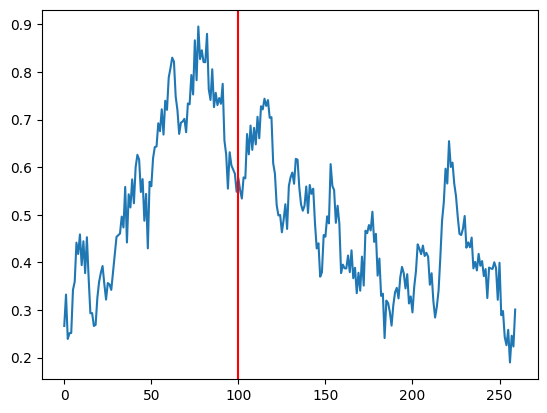

In [113]:
plt.plot(model.time_mask.weights.detach().squeeze().cpu().numpy())
plt.axvline(x=100, c='r')